# Quantum Black Holes (Group 4) - Quantum Corrections
(Suzanne Parr)

In astronomy the only thing we can detect is light. Understanding how it behaves near massive objects is essential to our understanding of black holes as a known form of "dark matter". 

The research goal is to understand how quantum effects can cause slight corrections to the path of light rays and also massive particles - in the vicinity of black holes. We start with the Schwarzschild metric describing motion in a spacetime governed by general relativity. This metric predicts orbital precession (observed in the orbit of planet Mercury), light deflection (lensing), and time dilation for a particle moving near a massive object. 

Here we add quantum corrections to our Schwarzschild black hole model. The corrections are derived in a paper by Saeed Rastgoo and colleagues. Past researchers found they could weave uncertainty-inspired quantum physics in a Schwarzschild black hole and the interior would behave according to observation but the math breaks down where spacetime flattens i.e. in the asymptotic region. To rectify this the team borrows an idea from 'Loop Quantum Gravity', namely that quantum parameters (QM) are momentum-dependent. This leads to an improvement to the interior model, which also works when extrapolated out to a full spacetime.

In [1]:
# import code libraries
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from scipy.integrate import solve_ivp
from scipy.integrate import quad
from scipy.signal import find_peaks
import sympy as sp
import OGRePy as gr
from IPython.display import display, Math
import matplotlib.animation as animation

**OGRePy: An <u>O</u>bject-Oriented <u>G</u>eneral <u>Re</u>lativity Package for <u>Py</u>thon\
By [Barak Shoshany](https://github.com/bshoshany) ([baraksh@gmail.com](mailto:baraksh@gmail.com)) ([baraksh.com](https://baraksh.com/))\
v1.3.0 (2025-02-04)\
GitHub repository: <https://github.com/bshoshany/OGRePy>\
Documentation: <a href="c:/Users/suzan/AppData/Local/Programs/Python/Python312/Lib/site-packages/OGRePy/docs/OGRePy_Documentation.ipynb">.ipynb</a>, <a href="c:/Users/suzan/AppData/Local/Programs/Python/Python312/Lib/site-packages/OGRePy/docs/OGRePy_Documentation.pdf">.pdf</a>, <a href="#" onclick="window.open('file:///c:/Users/suzan/AppData/Local/Programs/Python/Python312/Lib/site-packages/OGRePy/docs/OGRePy_Documentation.html', '_blank')">.html</a>**

**OGRePy**: You have the latest version of the package.

In [2]:
# assign r as a symbol
r = gr.sym('r', nonnegative=True)

# Improved Metric with Quantum Corrections

Here we define improved metric functions that work within the classical SC framework,

$$ ds^2 = - f(r) \, dt^2 + g(r) \, dr^2 + h(r) \left( d\theta^2 + \sin^2\theta \, d\phi^2 \right) $$

As with the SC metric the improved metric represents a static, spherically symmetric spacetime. Spherical symmetry means we can confine the direction of angular momentum to $\theta = \frac{\pi}{2}$ and the magnitude, defined as $L = h(r) \frac{d\phi}{d\lambda}$, is conserved. The metric is independent of 't' so energy, defined as, $E = f(r) \frac{dt}{d\lambda}$ is also conserved. If we integrate once we get expressions for $\dot{t}$, $\dot{r}^2$ and $\dot{\phi}$ in terms of the metric functions, the conserved quantities, E and L and $\epsilon$ (0 for null and 1 for time-like geodesics). If we re-arrange the radial component to isolate $E^2$ we can "read off" the Effective Potential,

$$V_{\text{eff}}(r) = f(r) \left( \frac{L^2}{h(r)} + \epsilon \right)$$

an expression that is comparable to Newtonian gravitational potential energy. Below we define the metric functions, Effective Potential, and Equations of Motion for the improved metric. We also get a new version of $\frac{dr}{d\lambda}$, 

$$\frac{dr}{d\lambda} = \left( \frac{1}{g(r)} \left( \frac{E^2}{f(r)} - \left( \epsilon + \frac{L^2}{h(r)} \right) \right) \right)^{\frac{1}{2}}$$


In [3]:
# block 1 - functions: Schwarzschild radius, quantum-corrected metric functions, effective potential and equations of motion.

# get schwarzschild radius from mass
def r_sc(M):
    return (2*M)

# schwarzschild metric functions (dependent on radial coordinate, r, SC radius and quantum corrections, Q_b, Q_c)
def f(r, M, Q_b, Q_c):
    return (1 + Q_b/r**2) * (1 + (Q_c*(2*M)**2)/(4*r**8))**(-1/4) * (1-(2*M)/(gr.s.sqrt(r**2+Q_b)))

def g(r, M, Q_b, Q_c):
    return (1 + (Q_c*(2*M)**2)/(4*r**8))**(1/4) * (1-(2*M)/(gr.s.sqrt(r**2+Q_b)))**(-1)

def h(r, M, Q_c):
    return r**2 * (1 + (Q_c*(2*M)**2)/(4*r**8))**(1/4)

# effective potential
def v_eff(r, M, L, Q_b, Q_c, epsilon=0):
    return f(r, M, Q_b, Q_c) * (L**2/h(r, M, Q_c) + epsilon)

def solve_dphi_dr(r, params, epsilon=1):
    r = float(r)
    E, L, M, Q_b, Q_c = params
    ff = float(f(r, M, Q_b, Q_c))
    gg = float(g(r, M, Q_b, Q_c))
    hh = float(h(r, M, Q_c))
    dphi_dlambda = L / hh
    squared = (1 / gg) * E**2 / ff - (epsilon + L**2 / hh)
    dr_dlambda = np.sqrt(abs(squared))
    dphi_dr = dphi_dlambda / dr_dlambda
    
    return dphi_dr

# lamda can be replaced by tau for massive particles
def eq_of_motion(lamda, y, params, epsilon=0):

    t, r, phi = y
    E, L, M, Q_b, Q_c = params

    dt_dlamda = E / f(r, M, Q_b, Q_c)
    dphi_dlamda = L / h(r, M, Q_c)
    squared = g(r, M, Q_b, Q_c)**(-1) * (E**2 / f(r, M, Q_b, Q_c) - (epsilon + L**2 / h(r, M, Q_c)))
    dr_dlamda = gr.s.sqrt(abs(squared))  # *** ensure non-negative input; obtain real part instead? ***

    return [dt_dlamda, dr_dlamda, dphi_dlamda]

# Assign Values to Constants

Assign values for Mass (M) of central massive object, Angular momentum (L) of the orbiting particle, a test value of Energy (E) and a set of values for the quantum parameters (QM) to see how quantum effects change effective potential.

In [4]:
# block 2 - assign test values for mass, energy, and angular momentum
M1 = 1.0  
rs1 = r_sc(M1)
r1 = 10 * rs1
# test values of quantum parameters
Q_b0 = 0.0
Q_b1 = 0.25
Q_b2 = 0.5
Q_b3 = 0.75
Q_b4 = 1.0
Q_c0 = 0.0
Q_c1 = 0.25
Q_c2 = 0.5
Q_c3 = 0.75
Q_c4 = 1.0

# conserved quantities
L1 = 3.8 # angular momentum of orbiting particle

# calculate and print SC metric components at a given radial distance from the BH, BH mass, and with Q_b = 0.5
f1 = f(r1, M1, Q_b0, Q_c0)
g1 = g(r1, M1, Q_b0, Q_c0)
h1 = h(r1, M1, Q_c0)

print(f"f(r) = {f1}")
print(f"g(r) = {g1}")
print(f"h(r) = {h1}")

f(r) = 0.900000000000000
g(r) = 1.11111111111111
h(r) = 400.0


# Effective Potential and Extrema

We find extrema by setting $\frac{dV_{\text{eff}}}{dr} = 0$ and solving for the (real) roots - values of 'r' where the slope of the effective potential is '0'.

In the case of light ($\epsilon = 0$) there is only a maximum at r = 3 * M when the quantum corrections (QM) = 0.

What follows is a function "find_extrema" that uses OGRePy's numerical function, nsolve to find the roots. For the case of light ($\epsilon = 0$) and a chosen value of angular momentum, L = 4.3 - a number that worked well - we can find the radial position, r, and value of $V_{\text{eff}}(r)$ at the maxima for a range of 13 $Q_b$ values between 0 and 1. Next "find_extrema" is run in a loop saving the $Q_b$ value and r, and $V_{\text{eff}}(r)$ values in an array for subsequent use in plotting trajectories. For this study we can ignore $Q_c$ (set it equal to 0) since $Q_b$ has a much larger effect and $Q_c$ is negligable by comparison. 

Finally we plot $V_{\text{eff}}(r)$ for L = 4.3 and at 13 $Q_b$ values with maximum potential (maxima) marked on the plot.

In [5]:
# block 3 - locate extrema for v_eff vs r (radial distance from a black hole). 
# extrema are found using OGRePy 'nsolve' numerically.
def find_extrema(M_val, L_val, Q_b_val, Q_c_val, eps_val, r_range):
    v_eff = f(r, M_val, Q_b_val, Q_c_val) * (L_val**2 / h(r, M_val, Q_c_val) + eps_val)

    # first derivative with respect to r
    dv_eff_dr = gr.s.diff(v_eff, r)
    # second derivative with respect to r
    d2v_eff_dr2 = gr.s.diff(dv_eff_dr, r)

    extrema = []
    # solve dv_eff_dr = 0 for a range of initial guesses
    for r_init in np.linspace(r_range[0], r_range[1], 50):
        try:
            root = gr.s.nsolve(dv_eff_dr, r, r_init)
            root = float(root)
            if not any(np.isclose(root, ext, atol=1e-6) for ext in extrema) and r_range[0] <= root <= r_range[1]:
                extrema.append(root) # ensure no "very close" extrema (tolerance of 10^-6); only pick values within the chosen r range. 
        except Exception:
            pass  # skip guess if nsolve fails

    extrema_results = []
    print(f"\nExtrema for ε = {eps_val}, M = {M1}, L = {L_val}, Q_b = {Q_b_val}, Q_c = {Q_c_val}:")
    for r_ex in extrema:
        v_eff_at_r = v_eff.subs(r, r_ex).evalf()  # evaluate symbolic function at values of r that rep extrema
        d2v_eff_dr2_r_ex = d2v_eff_dr2.subs(r, r_ex).evalf()  # 2nd derivative at extrema
        extrema_type = "min" if d2v_eff_dr2_r_ex > 0 else "max"
        extrema_results.append((r_ex, v_eff_at_r, extrema_type))
        print(f"r = {r_ex:.4f}, v_eff = {v_eff_at_r:.4f}, Type: {extrema_type}")

    return extrema_results, v_eff


Extrema for ε = 1.0, M = 1.0, L = 3.8, Q_b = 0.0, Q_c = 0.0:
r = 4.2521, v_eff = 0.9526, Type: max
r = 10.1879, v_eff = 0.9155, Type: min

Extrema for ε = 1.0, M = 1.0, L = 3.8, Q_b = 0.25, Q_c = 0.0:
r = 3.9526, v_eff = 0.9736, Type: max
r = 10.6394, v_eff = 0.9179, Type: min

Extrema for ε = 1.0, M = 1.0, L = 3.8, Q_b = 0.5, Q_c = 0.0:
r = 3.6820, v_eff = 0.9990, Type: max
r = 11.0603, v_eff = 0.9200, Type: min

Extrema for ε = 1.0, M = 1.0, L = 3.8, Q_b = 0.75, Q_c = 0.0:
r = 3.4322, v_eff = 1.0299, Type: max
r = 11.4584, v_eff = 0.9220, Type: min

Extrema for ε = 1.0, M = 1.0, L = 3.8, Q_b = 1.0, Q_c = 0.0:
r = 3.1978, v_eff = 1.0673, Type: max
r = 11.8389, v_eff = 0.9239, Type: min


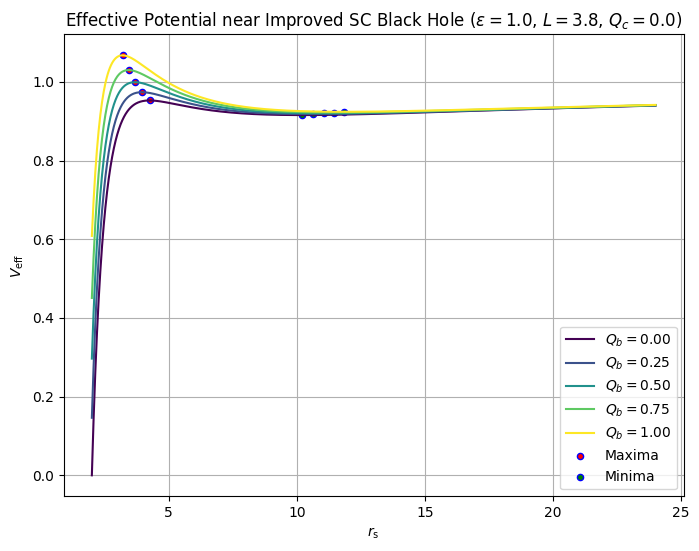

In [6]:
#block 4 - find v_eff max/min for the timelike case for different values of Q_b and create array for the results
r_range = (rs1, 12 * rs1)
eps = 1.0

Q_b_vals = np.linspace(0, 1.0, 5)
colors = plt.cm.viridis(np.linspace(0, 1, len(Q_b_vals)))
plt.figure(figsize=(8, 6))
max_x, max_y, min_x, min_y = [], [], [], []

# array to store extrema data: r, v_eff, Q_b
extrema_data = []

for Q_b, color in zip(Q_b_vals, colors):
    extrema, v_eff_func = find_extrema(M1, L1, Q_b, Q_c0, eps, r_range)
    r_vals1 = np.linspace(r_range[0], r_range[1], 1000)
    v_eff_func_num = sp.lambdify(r, v_eff_func, "numpy")
    v_eff_vals = v_eff_func_num(r_vals1)
    plt.plot(r_vals1, v_eff_vals, color=color, label=rf'$Q_b={Q_b:.2f}$')
    for r_ex, v_eff_at_r, ext_type in extrema:
        extrema_data.append((r_ex, v_eff_at_r, Q_b, ext_type))
        if ext_type == "max":
            max_x.append(r_ex)
            max_y.append(v_eff_at_r)
        else:
            min_x.append(r_ex)
            min_y.append(v_eff_at_r)

plt.scatter(max_x, max_y, color='r', s=20, edgecolors='b', label="Maxima")
plt.scatter(min_x, min_y, color='g', s=20, edgecolors='b', label="Minima")
plt.xlabel(r'$r_{\mathrm{s}}$')
plt.ylabel(r'$V_{\mathrm{eff}}$')
plt.title(rf"Effective Potential near Improved SC Black Hole ($\varepsilon={eps}$, $L={L1}$, $Q_c={Q_c0}$)")
plt.legend()
plt.grid(True)
plt.show()

# NumPy array with extrema data including: r, v_eff, Q_b val, extrema type
extrema_array = np.array(extrema_data)


In [14]:
# Print extrema_array
# print r(at v_max), v_max, Q_b, 'max'/'min') for Q_b = (0.0, 0.25, 0.50, 0.75, 1.0)
print(extrema_array[:, 0:4])

[[4.252105123155472 0.952648157123989 0.0 'max']
 [10.187894876844528 0.915499991024160 0.0 'min']
 [3.9525552339709655 0.973632508060842 0.25 'max']
 [10.639436315287034 0.917861413009015 0.25 'min']
 [3.6819500007353896 0.999048633929920 0.5 'max']
 [11.060320492712115 0.920026218088792 0.5 'min']
 [3.4321548831313233 1.02985154575437 0.75 'max']
 [11.458443833132666 0.922028329247097 0.75 'min']
 [3.1977915564419943 1.06733670374179 1.0 'max']
 [11.838899084624854 0.923892491584209 1.0 'min']]


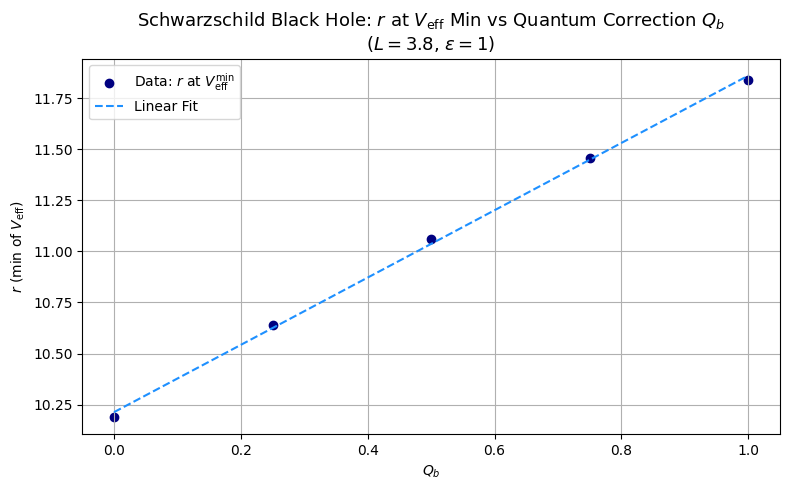

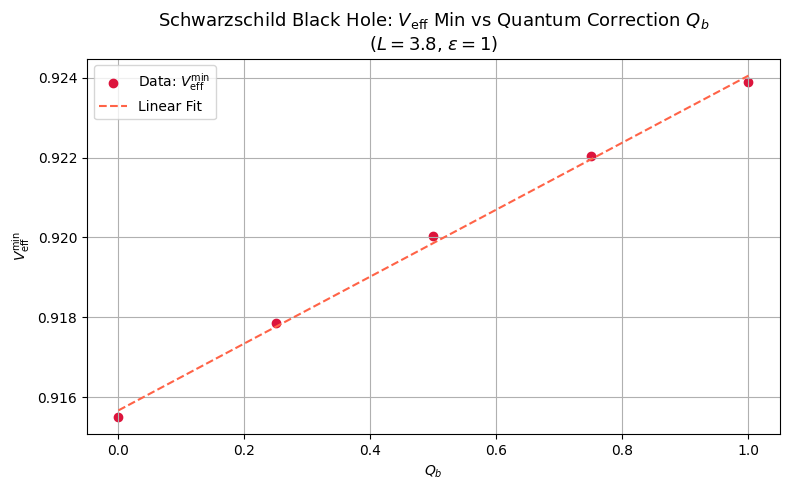

In [7]:
# Block 5 - plots of Q_b vs r and V_max
# extrema_array = np.array(extrema_data, dtype=object)

minima = extrema_array[extrema_array[:, 3] == 'min']

# Extract values
r_vals_min = np.array(minima[:, 0], dtype=float)
v_min_vals = np.array(minima[:, 1], dtype=float)
Q_b_vals_min = np.array(minima[:, 2], dtype=float)

# --- Fit a straight line: r_min vs Q_b ---
fit_r = np.polyfit(Q_b_vals_min, r_vals_min, 1)  # Linear fit: degree 1
fit_r_func = np.poly1d(fit_r)

# --- Fit a straight line: V_min vs Q_b ---
fit_v = np.polyfit(Q_b_vals_min, v_min_vals, 1)
fit_v_func = np.poly1d(fit_v)

# --- Plot 1: r_min vs Q_b with best-fit line ---
plt.figure(figsize=(8, 5))
plt.scatter(Q_b_vals_min, r_vals_min, color='navy', label=r'Data: $r$ at $V_{\mathrm{eff}}^{\min}$')
plt.plot(Q_b_vals_min, fit_r_func(Q_b_vals_min), color='dodgerblue', linestyle='--', label='Linear Fit')
plt.xlabel(r'$Q_b$')
plt.ylabel(r'$r$ (min of $V_{\mathrm{eff}}$)')
plt.title(r'Schwarzschild Black Hole: $r$ at $V_{\mathrm{eff}}$ Min vs Quantum Correction $Q_b$' + "\n" + rf'($L={L1}$, $\varepsilon=1$)', fontsize=13)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# --- Plot 2: V_min vs Q_b with best-fit line ---
plt.figure(figsize=(8, 5))
plt.scatter(Q_b_vals_min, v_min_vals, color='crimson', label=r'Data: $V_{\mathrm{eff}}^{\min}$')
plt.plot(Q_b_vals_min, fit_v_func(Q_b_vals_min), color='tomato', linestyle='--', label='Linear Fit')
plt.xlabel(r'$Q_b$')
plt.ylabel(r'$V_{\mathrm{eff}}^{\min}$')
plt.title(r'Schwarzschild Black Hole: $V_{\mathrm{eff}}$ Min vs Quantum Correction $Q_b$' + "\n" + rf'($L={L1}$, $\varepsilon=1$)', fontsize=13)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()




In [8]:
# block 6 - ODE Solver
def solve_bound_orbit(r_init, phi_init, t_init, lam_range, params, epsilon=1):
    E, L, M, Q_b, Q_c = params
    sign = -1  # Start moving inward
    flipped_on_this_neg = False

    # Check squared at the initial radius before integrating
    ff0 = float(f(r_init, M, Q_b, Q_c))
    gg0 = float(g(r_init, M, Q_b, Q_c))
    hh0 = float(h(r_init, M, Q_c))

    squared0 = (1/gg0) * (E**2 / ff0 - (epsilon + L**2 / hh0))
    print("Initial squared:", squared0)

    if squared0 < 0:
        print("Initial squared is negative. You're starting in a classically forbidden region.")
        # to prevent immediate outward motion, set flipped flag to True
        flipped_on_this_neg = True

    def dy_dt(lam, y):
        nonlocal sign, flipped_on_this_neg

        t, r, phi = y
        r = float(r)

        ff = float(f(r, M, Q_b, Q_c))
        gg = float(g(r, M, Q_b, Q_c))
        hh = float(h(r, M, Q_c))

        squared = (1/gg) * (E**2 / ff - (epsilon + L**2 / hh))

        if squared < 0 and not flipped_on_this_neg:
            sign *= -1
            flipped_on_this_neg = True
        elif squared >= 0:
            flipped_on_this_neg = False

        dt_dlam = E / ff
        dr_dlam = sign * np.sqrt(abs(squared))
        dphi_dlam = L / r**2

        return [dt_dlam, dr_dlam, dphi_dlam]

    def plunge_event(lam, y):
        r = y[1]
        return r - (2 * M)
    plunge_event.terminal = True
    plunge_event.direction = -1

    sol = solve_ivp(
        dy_dt,
        lam_range,
        [t_init, r_init, phi_init],
        t_eval=np.linspace(*lam_range, 2000),
        atol=1e-6,
        rtol=1e-6,
        events=plunge_event,
        max_step=0.2
    )

    if sol.status == 1:
        print("plunge detected — integration stopped.")

    r_vals = sol.y[1]
    phi_vals = np.unwrap(sol.y[2])

    return r_vals, phi_vals


In [9]:
# Block 7 - Find Energy Levels (E^2 = V(r_min) or E^2 = V(r_start))
E_sq0 = float(v_eff((float(extrema_array[1, 0]) + 0.005), M1, L1, Q_b0, Q_c0, epsilon=1))
E0 = np.sqrt(E_sq0)
print(E0)
E_sq1 = float(v_eff((float(extrema_array[3, 0]) + 0.005), M1, L1, Q_b1, Q_c0, epsilon=1))
E1 = np.sqrt(E_sq1)
print(E1)
E_sq2 = float(v_eff((float(extrema_array[5, 0]) + 0.005), M1, L1, Q_b2, Q_c0, epsilon=1))
E2 = np.sqrt(E_sq2)
print(E2)
E_sq3 = float(v_eff((float(extrema_array[7, 0]) + 0.005), M1, L1, Q_b3, Q_c0, epsilon=1))
E3 = np.sqrt(E_sq3)
print(E3)
E_sq4 = float(v_eff((float(extrema_array[9, 0]) + 0.005), M1, L1, Q_b4, Q_c0, epsilon=1))
E4 = np.sqrt(E_sq4)
print(E4)

0.9568176444801415
0.9580508472673962
0.959179978017005
0.9602230681629852
0.9611932699868047


# Particle Orbits ($\epsilon$ = 1) with Quantum Corrections

For M = 1.0 and L = 3.8 there is the possibility for a bound orbit close to the $V_{\text{eff}}(r)$ minima if the total energy of the particle is just above the minima. If ($Q_b$ = 0) a minimum exists at 10.19; if ($Q_b$ = 0.5) a minimum exists at 11.06; and if ($Q_b$ = 1.0) a mimumum exists at 11.84. As $Q_b$ increases from 0 to 1 the minima are located at larger r and at higher values of $V_{\text{eff}}(r)$. 

Next: using the array of minima for $V_{\text{eff}}(r)$ for different values of $Q_b$ we can pinpoint the r values where a bound orbit can be and observe and plot orbital precession.

Initial squared: 0.0018319155095816574
Initial squared: 0.0018325971738693946
Initial squared: 0.001833485286604713
Initial squared: 0.0018345086102477715
Initial squared: 0.001835623281373292


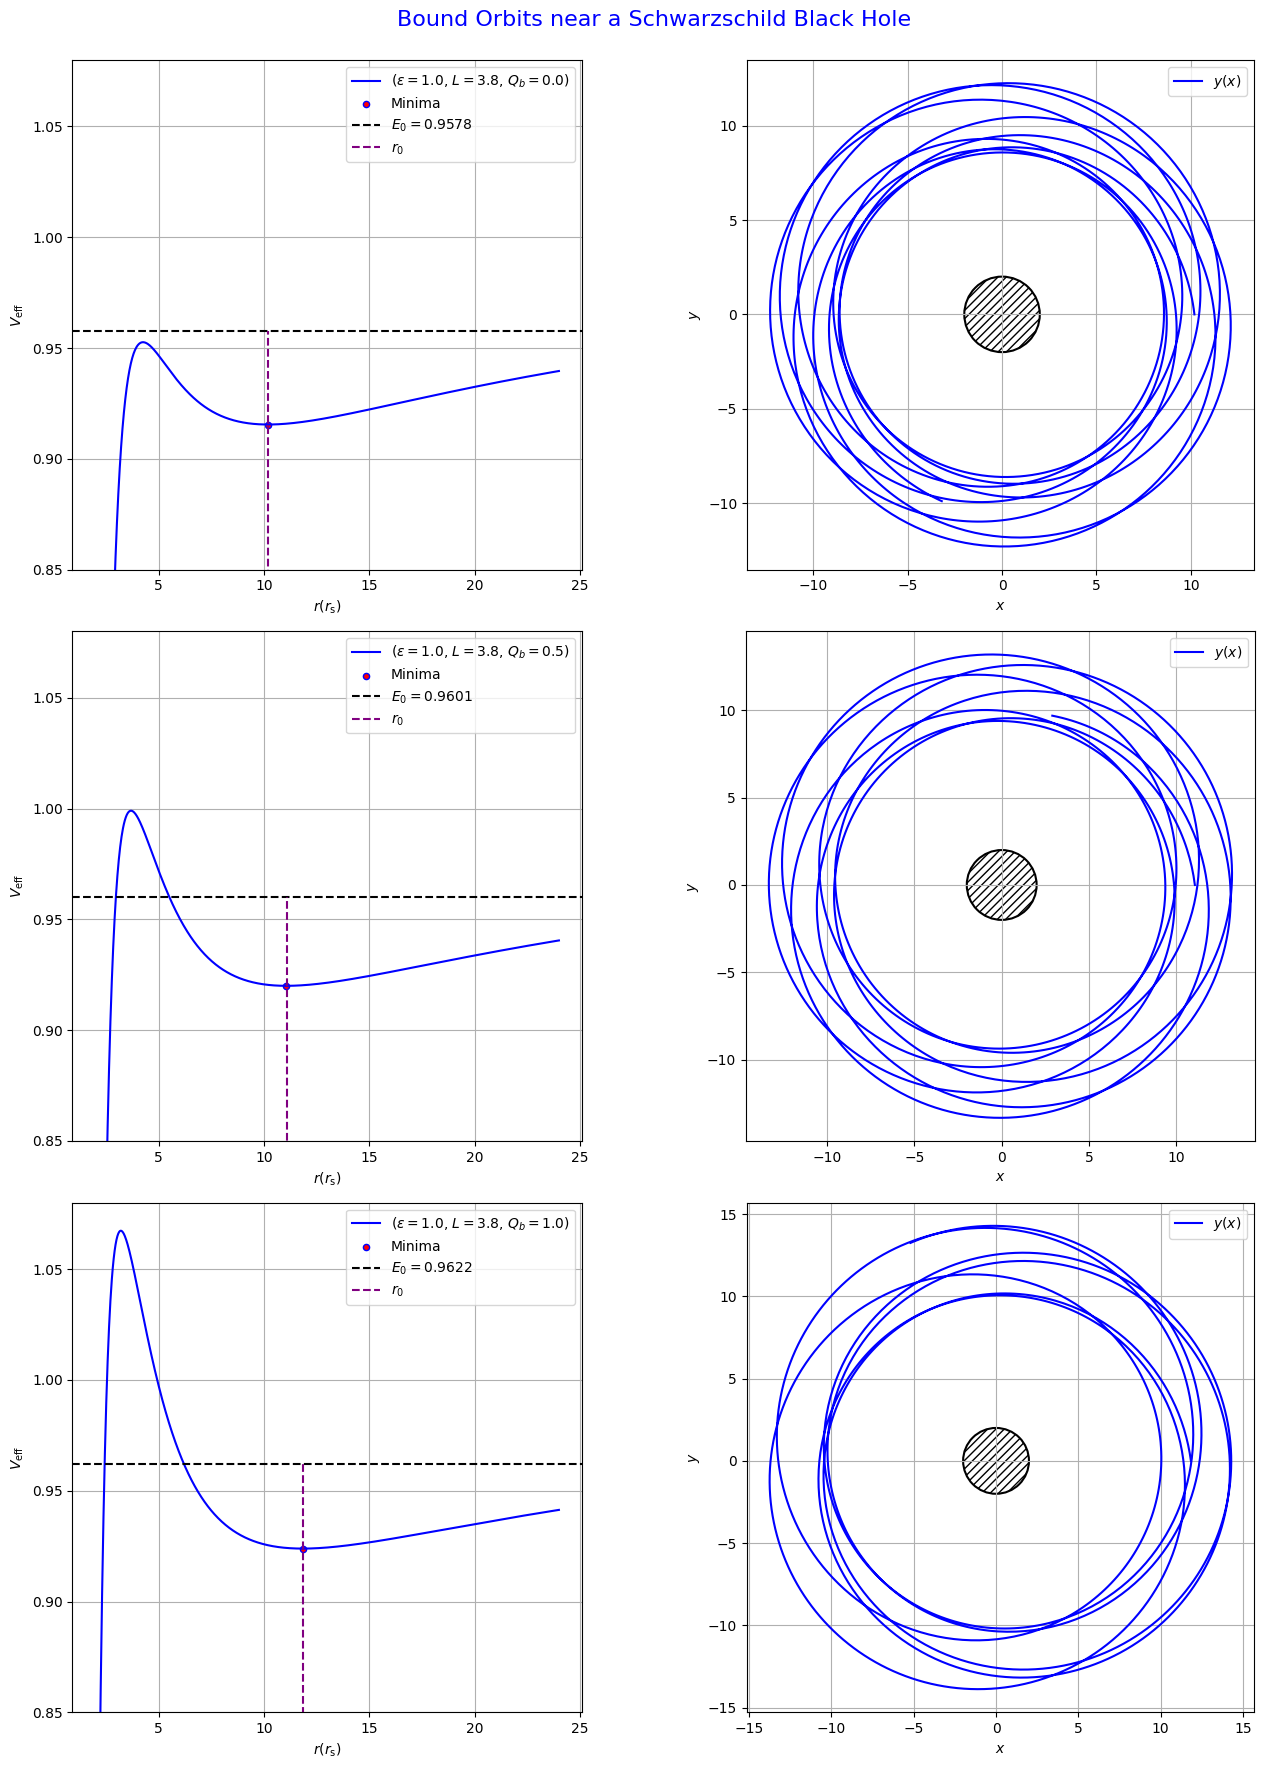

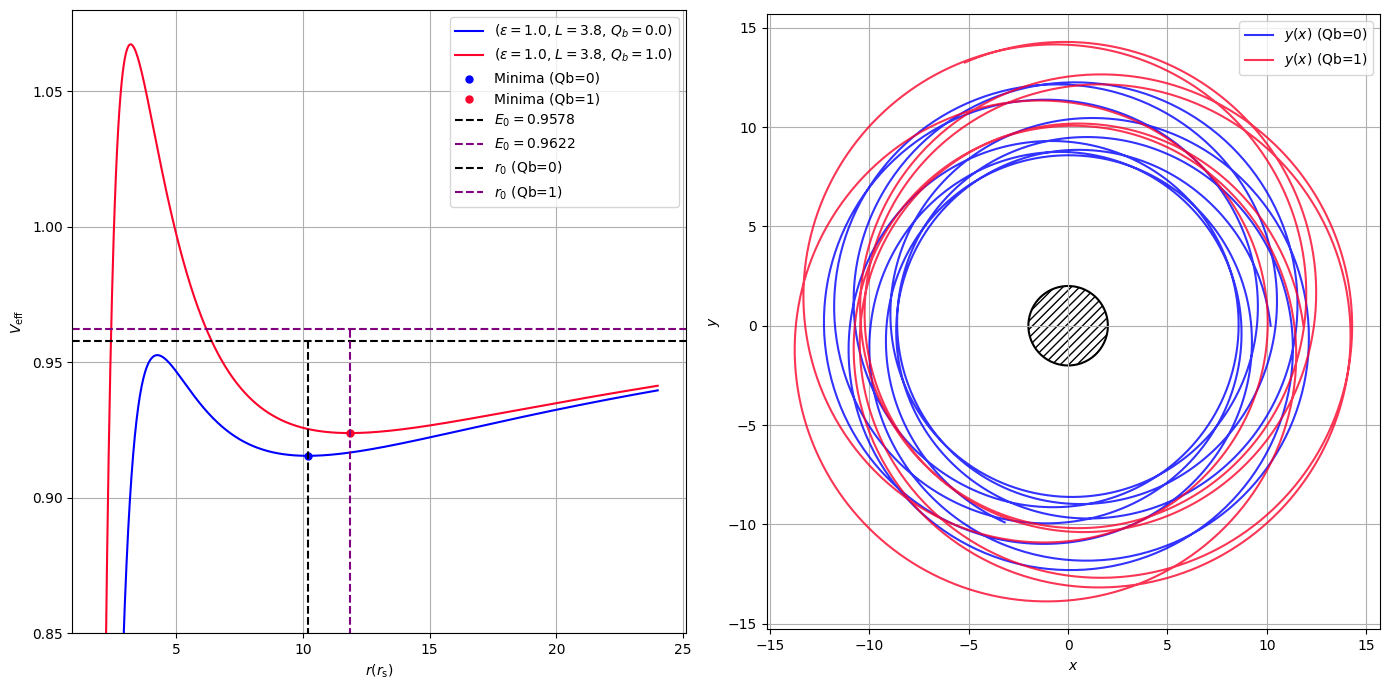

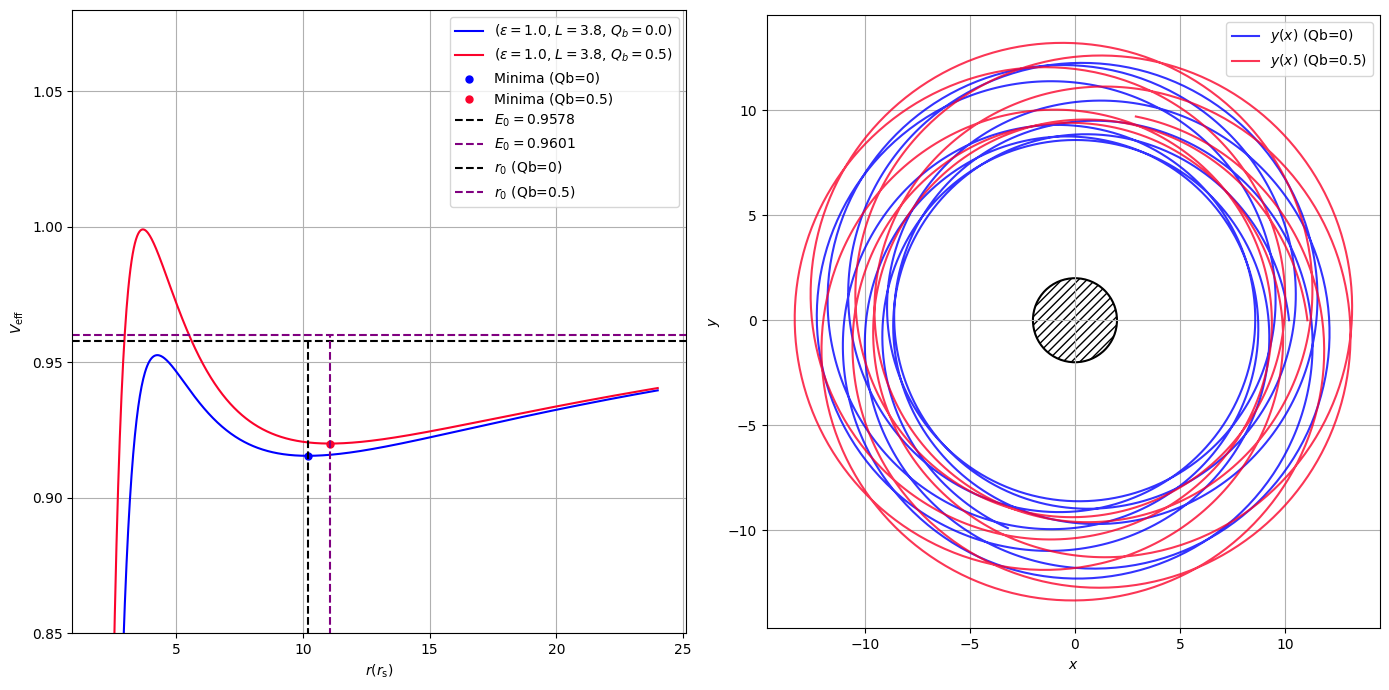

In [53]:
# block 8 - bound plots for time-like case (epsilon = 1)
phi_init = 0.0
t_init = 0.0
lam_range0 = [0,1500]
eps = 1.0
# Plots only for Q_b = 0, 0.5, 1.0
#----------- Q_b = 0 ------------------#
Qb_val0 = float(extrema_array[1, 2])
r_init0 = float(extrema_array[1, 0]) + 0.005
# E_val2 = np.sqrt(float(extrema_array[1, 1])) #v_eff at max (= E)
#E_val0 = E0 + 0.001
E_val0 = E0 * 1.001
params0 = (E_val0, L1, M1, Qb_val0, Q_c0)

r_0 = np.linspace(rs1, 12*rs1, 1000)
v_eff_0 = np.array([v_eff(i, M1, L1, Qb_val0, Q_c0, epsilon=1) for i in r_0])

r_vals0, phi_vals0 = solve_bound_orbit(r_init0, phi_init, t_init, lam_range=lam_range0, params=params0)

x_vals0 = r_vals0 * np.cos(phi_vals0)
y_vals0 = r_vals0 * np.sin(phi_vals0)

#---------- Q_b = 0.25 -------------
Qb_val1 = float(extrema_array[3, 2])
r_init1 = float(extrema_array[3, 0]) + 0.005
# E_val1 = np.sqrt(float(extrema_array[3, 1])) #v_eff at max (= E)
# E_val1 = E1 + 0.001
E_val1 = E1 * 1.001
params1 = (E_val1, L1, M1, Qb_val1, Q_c0)

v_eff_1 = np.array([v_eff(i, M1, L1, Qb_val1, Q_c0, epsilon=1) for i in r_0])

r_vals1, phi_vals1 = solve_bound_orbit(r_init1, phi_init, t_init, lam_range=lam_range0, params=params1)

x_vals1 = r_vals1 * np.cos(phi_vals1)
y_vals1 = r_vals1 * np.sin(phi_vals1)

#---------- Q_b = 0.5 -------------
Qb_val2 = float(extrema_array[5, 2])
r_init2 = float(extrema_array[5, 0]) + 0.005
# E_val2 = np.sqrt(float(extrema_array[5, 1])) #v_eff at max (= E)
# E_val2 = E2 + 0.001
E_val2 = E2 * 1.001
params2 = (E_val2, L1, M1, Qb_val2, Q_c0)

v_eff_2 = np.array([v_eff(i, M1, L1, Qb_val2, Q_c0, epsilon=1) for i in r_0])

r_vals2, phi_vals2 = solve_bound_orbit(r_init2, phi_init, t_init, lam_range=lam_range0, params=params2)

# cartesian coordinates
x_vals2 = r_vals2 * np.cos(phi_vals2)
y_vals2 = r_vals2 * np.sin(phi_vals2)

#---------- Q_b = 0.75 -------------
Qb_val3 = float(extrema_array[7, 2])
r_init3 = float(extrema_array[7, 0]) + 0.005
# E_val3 = np.sqrt(float(extrema_array[5, 1])) #v_eff at max (= E)
# E_val3 = E3 + 1.001
E_val3 = E3 * 1.001
params3 = (E_val3, L1, M1, Qb_val3, Q_c0)

v_eff_3 = np.array([v_eff(i, M1, L1, Qb_val3, Q_c0, epsilon=1) for i in r_0])

r_vals3, phi_vals3 = solve_bound_orbit(r_init3, phi_init, t_init, lam_range=lam_range0, params=params3)

x_vals3 = r_vals3 * np.cos(phi_vals3)
y_vals3 = r_vals3 * np.sin(phi_vals3)

#---------- Q_b = 1.0 -------------
Qb_val4 = float(extrema_array[9, 2])
r_init4 = float(extrema_array[9, 0]) + 0.005
# E_val4 = np.sqrt(float(extrema_array[9, 1]))
# E_val4 = E4 + 0.001
E_val4 = E4 * 1.001
params4 = (E_val4, L1, M1, Qb_val4, Q_c0)

v_eff_4 = np.array([v_eff(i, M1, L1, Qb_val4, Q_c0, epsilon=1) for i in r_0])

r_vals4, phi_vals4 = solve_bound_orbit(r_init4, phi_init, t_init, lam_range=lam_range0, params=params4)

x_vals4 = r_vals4 * np.cos(phi_vals4)
y_vals4 = r_vals4 * np.sin(phi_vals4)
#--------- Plots -------------
fig, axes = plt.subplots(3, 2, figsize=(14, 18))

for i in range(3): 
    axes[i, 0].set_box_aspect(1)  # landscape for eff. potential plots
    axes[i, 1].set_aspect('equal')  # square for orbit plots

# plot 1
axes[0, 0].plot(r_0, v_eff_0, label=rf"($\varepsilon={eps}$, $L={L1}$, $Q_b={Qb_val0}$)", color='b')
axes[0, 0].scatter(extrema_array[1,0], extrema_array[1,1], color='r', s=20, edgecolors='b', label="Minima")
axes[0, 0].axhline(y=E_val0, color='black', linestyle='--', label=rf'$E_0 = {E_val0:.4f}$')
axes[0, 0].vlines(x=r_init0, ymin=min(v_eff_0), ymax=E_val0, color='purple', linestyle='--', label=r'$r_0$')
axes[0, 0].set_xlabel(r'$r(r_{\mathrm{s}})$')
axes[0, 0].set_ylabel(r'$V_{\mathrm{eff}}$')
axes[0, 0].legend()
axes[0, 0].grid()
axes[0, 0].set_ylim(0.85, 1.08)  

# plot 2
axes[0, 1].plot(x_vals0, y_vals0, label=r'$y(x)$', color='blue')
circle1_1 = patches.Circle((0, 0), 2*M1, edgecolor='black', facecolor='none', hatch='////', linewidth=1.5)
axes[0, 1].add_patch(circle1_1)
axes[0, 1].set_xlabel(r'$x$')
axes[0, 1].set_ylabel(r'$y$')
axes[0, 1].legend()
axes[0, 1].grid()

# plot 3
axes[1, 0].plot(r_0, v_eff_2, label=rf"($\varepsilon={eps}$, $L={L1}$, $Q_b={Qb_val2}$)", color='b')
axes[1, 0].scatter(extrema_array[5,0], extrema_array[5,1], color='r', s=20, edgecolors='b', label="Minima")
axes[1, 0].axhline(y=E_val2, color='black', linestyle='--', label=rf'$E_0 = {E_val2:.4f}$')
axes[1, 0].vlines(x=r_init2, ymin=min(v_eff_2), ymax=E_val2, color='purple', linestyle='--', label=r'$r_0$')
axes[1, 0].set_xlabel(r'$r(r_{\mathrm{s}})$')
axes[1, 0].set_ylabel(r'$V_{\mathrm{eff}}$')
axes[1, 0].legend()
axes[1, 0].grid()
axes[1, 0].set_ylim(0.85, 1.08)  

# plot 4
axes[1, 1].plot(x_vals2, y_vals2, label=r'$y(x)$', color='blue')
circle2_1 = patches.Circle((0, 0), 2*M1, edgecolor='black', facecolor='none', hatch='////', linewidth=1.5)
axes[1, 1].add_patch(circle2_1)
axes[1, 1].set_xlabel(r'$x$')
axes[1, 1].set_ylabel(r'$y$')
axes[1, 1].legend()
axes[1, 1].grid()

# plot 5
axes[2, 0].plot(r_0, v_eff_4, label=rf"($\varepsilon={eps}$, $L={L1}$, $Q_b={Qb_val4}$)", color='b')
axes[2, 0].scatter(extrema_array[9,0], extrema_array[9,1], color='r', s=20, edgecolors='b', label="Minima")
axes[2, 0].axhline(y=E_val4, color='black', linestyle='--', label=rf'$E_0 = {E_val4:.4f}$')
axes[2, 0].vlines(x=r_init4, ymin=min(v_eff_4), ymax=E_val4, color='purple', linestyle='--', label=r'$r_0$')
axes[2, 0].set_xlabel(r'$r(r_{\mathrm{s}})$')
axes[2, 0].set_ylabel(r'$V_{\mathrm{eff}}$')
axes[2, 0].legend()
axes[2, 0].grid()
axes[2, 0].set_ylim(0.85, 1.08)  

# plot 6
axes[2, 1].plot(x_vals4, y_vals4, label=r'$y(x)$', color='blue')
circle3_1 = patches.Circle((0, 0), 2*M1, edgecolor='black', facecolor='none', hatch='////', linewidth=1.5)
axes[2, 1].add_patch(circle3_1)
axes[2, 1].set_xlabel(r'$x$')
axes[2, 1].set_ylabel(r'$y$')
axes[2, 1].legend()
axes[2, 1].grid()

# ---- titles ---- #
fig.suptitle("Bound Orbits near a Schwarzschild Black Hole", color='b', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.98]) 
plt.show()
#------- overlay plot Qb = 0, 1 -------------------
fig, axes = plt.subplots(1, 2, figsize=(14, 7), gridspec_kw={'width_ratios': [1, 1]})  

# left plot: effective potentials
axes[0].plot(r_0, v_eff_0, label=rf"($\varepsilon={eps}$, $L={L1}$, $Q_b={Qb_val0}$)", color='b')
axes[0].plot(r_0, v_eff_4, label=rf"($\varepsilon={eps}$, $L={L1}$, $Q_b={Qb_val4}$)", color='#fb032b')
axes[0].scatter(extrema_array[1, 0], extrema_array[1, 1], color='b', s=25, edgecolors='b', label="Minima (Qb=0)")
axes[0].scatter(extrema_array[9, 0], extrema_array[9, 1], color='#fb032b', s=25, edgecolors='#fb032b', label="Minima (Qb=1)")
axes[0].axhline(y=E_val0, color='black', linestyle='--', label=rf'$E_0 = {E_val0:.4f}$')
axes[0].axhline(y=E_val4, color='purple', linestyle='--', label=rf'$E_0 = {E_val4:.4f}$')
axes[0].vlines(x=r_init0, ymin=min(v_eff_0), ymax=E_val0, color='black', linestyle='--', label=r'$r_0$ (Qb=0)')
axes[0].vlines(x=r_init4, ymin=min(v_eff_4), ymax=E_val4, color='purple', linestyle='--', label=r'$r_0$ (Qb=1)')
axes[0].set_xlabel(r'$r(r_{\mathrm{s}})$')
axes[0].set_ylabel(r'$V_{\mathrm{eff}}$')
axes[0].set_ylim(0.85, 1.08)  # Limit y-axis to start at 0.4
axes[0].legend()
axes[0].grid()

# right plot: overlaid orbits (square)
axes[1].plot(x_vals0, y_vals0, label=r'$y(x)$ (Qb=0)', color='b', alpha=0.8)  # Dark Blue
axes[1].plot(x_vals4, y_vals4, label=r'$y(x)$ (Qb=1)', color='#fb032b', alpha=0.8) 
circle = patches.Circle((0, 0), 2*M1, edgecolor='black', facecolor='none', hatch='////', linewidth=1.5)
axes[1].add_patch(circle)
axes[1].set_xlabel(r'$x$')
axes[1].set_ylabel(r'$y$')
axes[1].set_aspect('equal') 
axes[1].legend()
axes[1].grid()

plt.tight_layout()
plt.show()

#------- overlay plot Qb = 0, 0.5 -------------------
fig, axes = plt.subplots(1, 2, figsize=(14, 7), gridspec_kw={'width_ratios': [1, 1]})  

# left plot: effective potentials
axes[0].plot(r_0, v_eff_0, label=rf"($\varepsilon={eps}$, $L={L1}$, $Q_b={Qb_val0}$)", color='b')
axes[0].plot(r_0, v_eff_2, label=rf"($\varepsilon={eps}$, $L={L1}$, $Q_b={Qb_val2}$)", color='#fb032b')
axes[0].scatter(extrema_array[1, 0], extrema_array[1, 1], color='b', s=25, edgecolors='b', label="Minima (Qb=0)")
axes[0].scatter(extrema_array[5, 0], extrema_array[5, 1], color='#fb032b', s=25, edgecolors='#fb032b', label="Minima (Qb=0.5)")
axes[0].axhline(y=E_val0, color='black', linestyle='--', label=rf'$E_0 = {E_val0:.4f}$')
axes[0].axhline(y=E_val2, color='purple', linestyle='--', label=rf'$E_0 = {E_val2:.4f}$')
axes[0].vlines(x=r_init0, ymin=min(v_eff_0), ymax=E_val0, color='black', linestyle='--', label=r'$r_0$ (Qb=0)')
axes[0].vlines(x=r_init2, ymin=min(v_eff_2), ymax=E_val2, color='purple', linestyle='--', label=r'$r_0$ (Qb=0.5)')
axes[0].set_xlabel(r'$r(r_{\mathrm{s}})$')
axes[0].set_ylabel(r'$V_{\mathrm{eff}}$')
axes[0].set_ylim(0.85, 1.08)  # Limit y-axis to start at 0.4
axes[0].legend()
axes[0].grid()

# right plot: overlaid orbits (square)
axes[1].plot(x_vals0, y_vals0, label=r'$y(x)$ (Qb=0)', color='b', alpha=0.8)  # Dark Blue
axes[1].plot(x_vals2, y_vals2, label=r'$y(x)$ (Qb=0.5)', color='#fb032b', alpha=0.8) 
circle = patches.Circle((0, 0), 2*M1, edgecolor='black', facecolor='none', hatch='////', linewidth=1.5)
axes[1].add_patch(circle)
axes[1].set_xlabel(r'$x$')
axes[1].set_ylabel(r'$y$')
axes[1].set_aspect('equal') 
axes[1].legend()
axes[1].grid()

plt.tight_layout()
plt.show()


Initial squared: 0.008597685211473447
Initial squared: 0.0002037353629066731


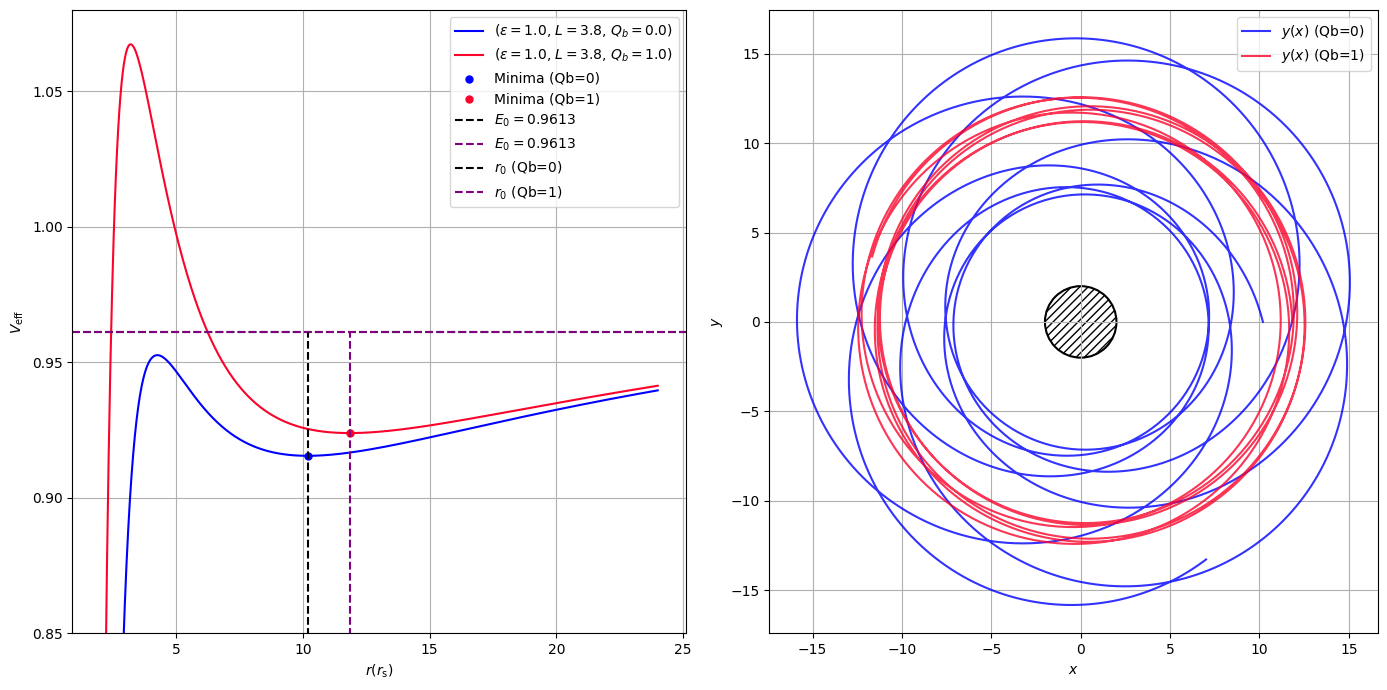

In [ ]:
# Block 8B - Bound Plots (Equal Energy Test)
phi_init = 0.0
t_init = 0.0
lam_range6 = [0,1500]
eps = 1.0
# Plots only for Q_b = 0, 0.5, 1.0
#----------- Q_b = 0 ------------------#
Qb_val6 = float(extrema_array[1, 2])
r_init6 = float(extrema_array[1, 0]) + 0.005
#E_val6 = E0 + 0.001
E_val6 = 0.9613
params6 = (E_val6, L1, M1, Qb_val6, Q_c0)

r_6 = np.linspace(rs1, 12*rs1, 1000)
v_eff_6 = np.array([v_eff(i, M1, L1, Qb_val6, Q_c0, epsilon=1) for i in r_6])

r_vals6, phi_vals6 = solve_bound_orbit(r_init6, phi_init, t_init, lam_range=lam_range6, params=params6)

x_vals6 = r_vals6 * np.cos(phi_vals6)
y_vals6 = r_vals6 * np.sin(phi_vals6)
#---------- Q_b = 1.0 -------------
Qb_val7 = float(extrema_array[9, 2])
r_init7 = float(extrema_array[9, 0]) + 0.005
# E_val4 = np.sqrt(float(extrema_array[9, 1]))
# E_val7 = E4 + 0.001
E_val7 = 0.9613
params7 = (E_val7, L1, M1, Qb_val7, Q_c0)

v_eff_7 = np.array([v_eff(i, M1, L1, Qb_val7, Q_c0, epsilon=1) for i in r_6])

r_vals7, phi_vals7 = solve_bound_orbit(r_init7, phi_init, t_init, lam_range=lam_range6, params=params7)

x_vals7 = r_vals7 * np.cos(phi_vals7)
y_vals7 = r_vals7 * np.sin(phi_vals7)
#--------- Plots -------------
fig, axes = plt.subplots(1, 2, figsize=(14, 7), gridspec_kw={'width_ratios': [1, 1]})  

# left plot: effective potentials
axes[0].plot(r_6, v_eff_6, label=rf"($\varepsilon={eps}$, $L={L1}$, $Q_b={Qb_val6}$)", color='b')
axes[0].plot(r_6, v_eff_7, label=rf"($\varepsilon={eps}$, $L={L1}$, $Q_b={Qb_val7}$)", color='#fb032b')
axes[0].scatter(extrema_array[1, 0], extrema_array[1, 1], color='b', s=25, edgecolors='b', label="Minima (Qb=0)")
axes[0].scatter(extrema_array[9, 0], extrema_array[9, 1], color='#fb032b', s=25, edgecolors='#fb032b', label="Minima (Qb=1)")
axes[0].axhline(y=E_val6, color='black', linestyle='--', label=rf'$E_0 = {E_val6:.4f}$')
axes[0].axhline(y=E_val7, color='purple', linestyle='--', label=rf'$E_0 = {E_val7:.4f}$')
axes[0].vlines(x=r_init6, ymin=min(v_eff_6), ymax=E_val6, color='black', linestyle='--', label=r'$r_0$ (Qb=0)')
axes[0].vlines(x=r_init7, ymin=min(v_eff_7), ymax=E_val7, color='purple', linestyle='--', label=r'$r_0$ (Qb=1)')
axes[0].set_xlabel(r'$r(r_{\mathrm{s}})$')
axes[0].set_ylabel(r'$V_{\mathrm{eff}}$')
axes[0].set_ylim(0.85, 1.08)  # Limit y-axis to start at 0.4
axes[0].legend()
axes[0].grid()

# right plot: overlaid orbits (square)
axes[1].plot(x_vals6, y_vals6, label=r'$y(x)$ (Qb=0)', color='b', alpha=0.8)  # Dark Blue
axes[1].plot(x_vals7, y_vals7, label=r'$y(x)$ (Qb=1)', color='#fb032b', alpha=0.8) 
circle = patches.Circle((0, 0), 2*M1, edgecolor='black', facecolor='none', hatch='////', linewidth=1.5)
axes[1].add_patch(circle)
axes[1].set_xlabel(r'$x$')
axes[1].set_ylabel(r'$y$')
axes[1].set_aspect('equal') 
axes[1].legend()
axes[1].grid()

plt.tight_layout()
plt.show()


#---------------------------

In [ ]:
# Block 9 - calculate Perihelion Shift with r_min and r_max
def process_phi_vs_r(r_vals, phi_vals, Qb_val, E_val, L_val, plot=True):
    # find minima and maxima (perihelion/aphelion)
    min_indices, _ = find_peaks(-r_vals)
    max_indices, _ = find_peaks(r_vals)

    r_mins = r_vals[min_indices]
    phi_mins = phi_vals[min_indices]
    r_maxs = r_vals[max_indices]
    phi_maxs = phi_vals[max_indices]

    # plot phi(r) with labeled extrema
    if plot:
        plt.figure(figsize=(8, 5))
        plt.plot(r_vals, phi_vals, label=r"$\phi(r)$", lw=2)
        plt.scatter(r_mins, phi_mins, color='red', label="Perihelion", zorder=5)
        plt.scatter(r_maxs, phi_maxs, color='blue', label="Aphelion", zorder=5)

        for i in range(len(r_mins)):  # Label all perihelion points
            plt.annotate(f"{i}", (r_mins[i], phi_mins[i]), textcoords="offset points", xytext=(5,5), ha='center', color='red')
        for i in range(len(r_maxs)):  # Label all aphelion points
            plt.annotate(f"{i}", (r_maxs[i], phi_maxs[i]), textcoords="offset points", xytext=(5,5), ha='center', color='blue')

        plt.xlabel("r")
        plt.ylabel(r"$\phi$ (radians)")
        plt.title(fr"Perihelion Shift: $\phi$ vs. Radius (E={E_val:.4f}, L={L_val:.2f}, Q_b={Qb_val:.2f})")
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()

    # compute average perihelion shift from phi values
    if len(phi_mins) >= 2:
        delta_phis = np.diff(phi_mins) % (2 * np.pi)
        avg_shift = np.mean(delta_phis)
    else:
        avg_shift = np.nan 

    return avg_shift


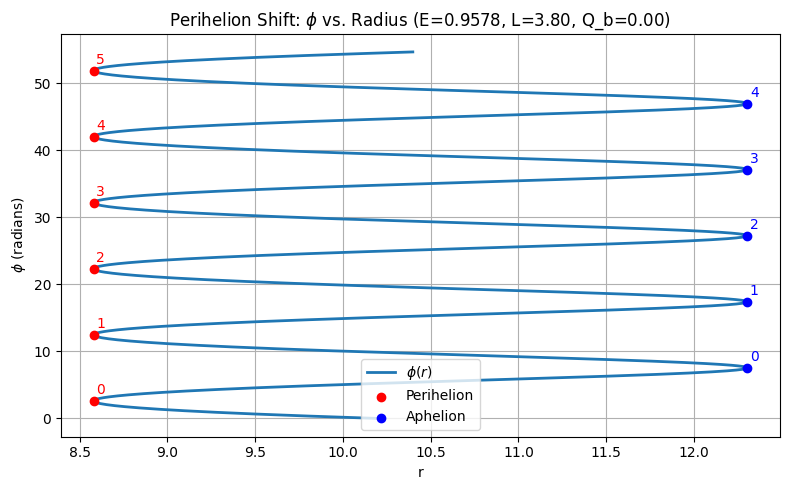

Q_b = 0.00 -> ⟨Δφ⟩ = 3.573089 rad


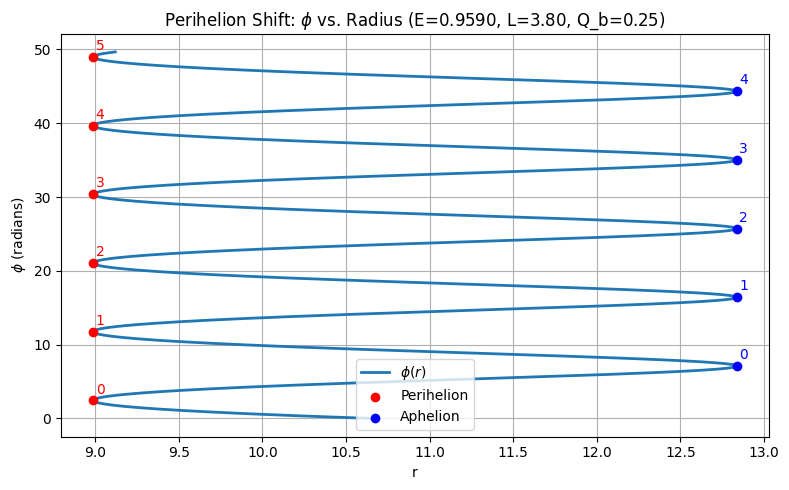

Q_b = 0.25 -> ⟨Δφ⟩ = 3.030158 rad


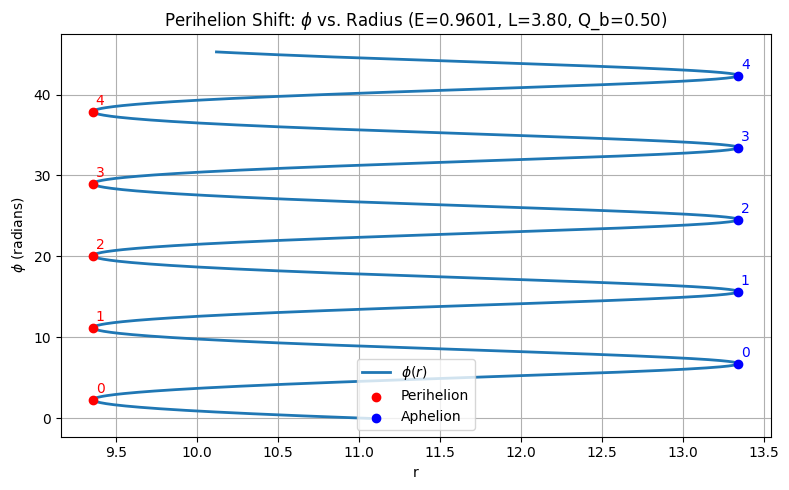

Q_b = 0.50 -> ⟨Δφ⟩ = 2.615785 rad


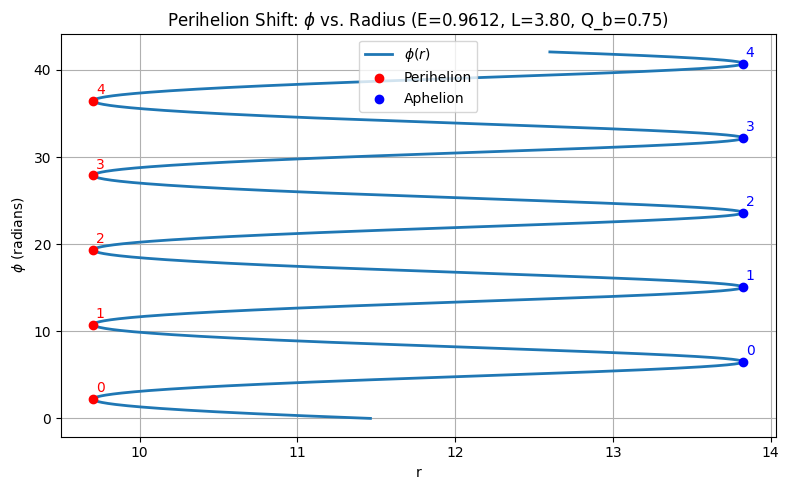

Q_b = 0.75 -> ⟨Δφ⟩ = 2.275568 rad


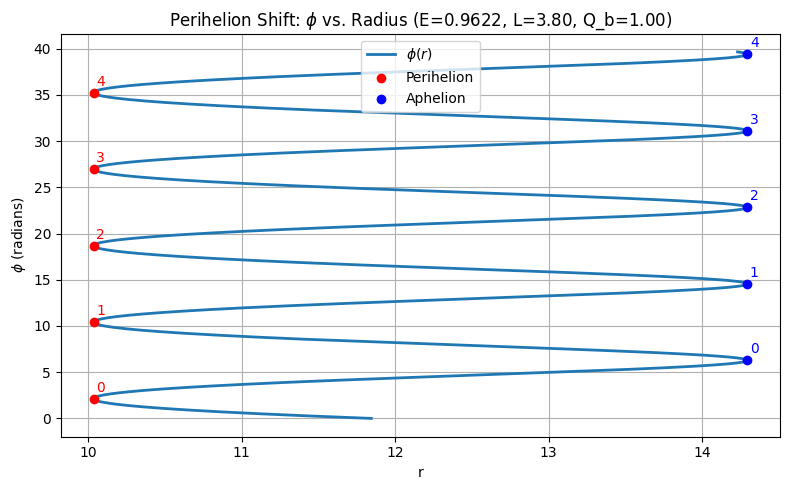

Q_b = 1.00 -> ⟨Δφ⟩ = 1.997286 rad


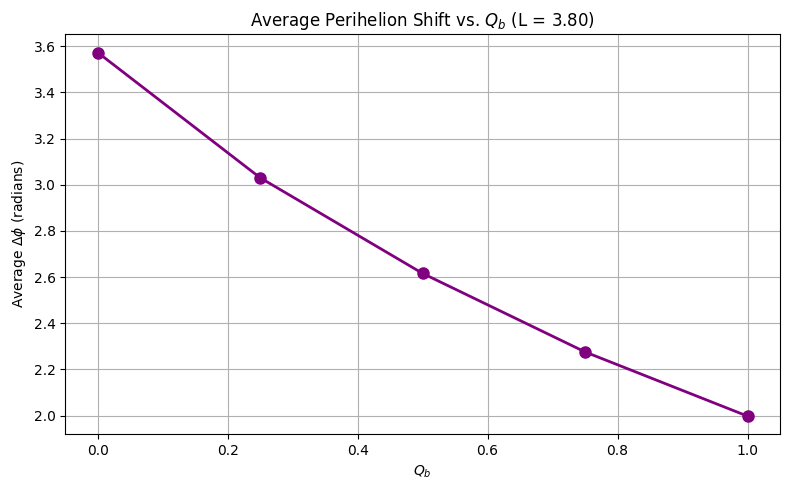

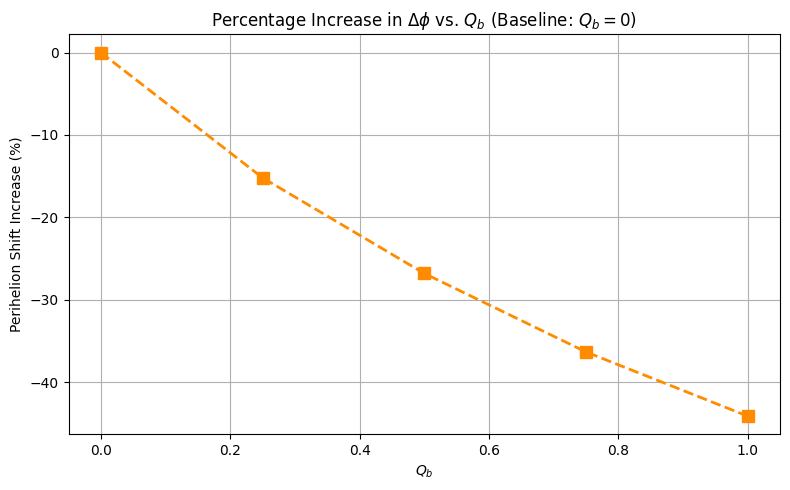


Percentage increase from Q_b = 0 to Q_b = 1.0: -44.10%


In [ ]:
# Block 10 - Calculate perihelion shift for previously created datasets
Qb_vals = [Qb_val0, Qb_val1, Qb_val2, Qb_val3, Qb_val4]
r_list   = [r_vals0, r_vals1, r_vals2, r_vals3, r_vals4]
phi_list = [phi_vals0, phi_vals1, phi_vals2, phi_vals3, phi_vals4]
E_vals   = [E_val0, E_val1, E_val2, E_val3, E_val4]

delta_phis = []

for i in range(len(Qb_vals)):
    dphi = process_phi_vs_r(r_list[i], phi_list[i], Qb_vals[i], E_vals[i], L1)
    delta_phis.append(dphi)
    print(f"Q_b = {Qb_vals[i]:.2f} -> ⟨Δφ⟩ = {dphi:.6f} rad")

plt.figure(figsize=(8, 5))
plt.plot(Qb_vals, delta_phis, 'o-', color='purple', lw=2, markersize=8)
plt.xlabel(r"$Q_b$")
plt.ylabel(r"Average $\Delta\phi$ (radians)")
plt.title(fr"Average Perihelion Shift vs. $Q_b$ (L = {L1:.2f})")
plt.grid(True)
plt.tight_layout()
plt.show()
#------- plot percentage increase in perihelion shift -----
delta_phis = np.array(delta_phis)

# Q_b = 0 value is the baseline
baseline_shift = delta_phis[0]

percent_increase_vals = ((delta_phis - baseline_shift) / baseline_shift) * 100

plt.figure(figsize=(8, 5))
plt.plot(Qb_vals, percent_increase_vals, 's--', color='darkorange', lw=2, markersize=8)
plt.xlabel(r"$Q_b$")
plt.ylabel(r"Perihelion Shift Increase (%)")
plt.title(fr"Percentage Increase in $\Delta\phi$ vs. $Q_b$ (Baseline: $Q_b = 0$)")
plt.grid(True)
plt.tight_layout()
plt.show()

print(f"\nPercentage increase from Q_b = 0 to Q_b = 1.0: {percent_increase_vals[-1]:.2f}%")


Initial squared: 0.0018217899531600896


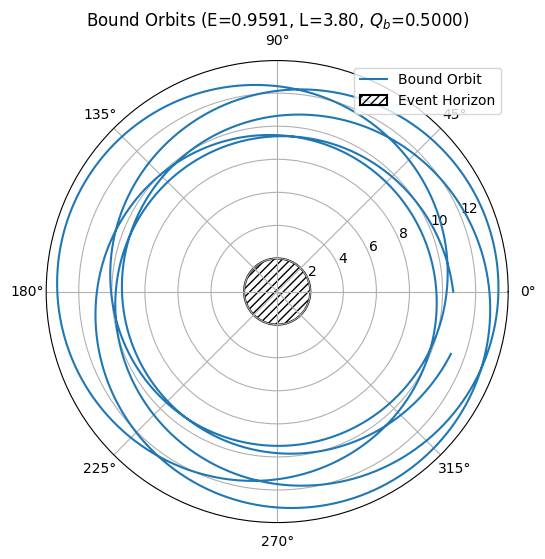

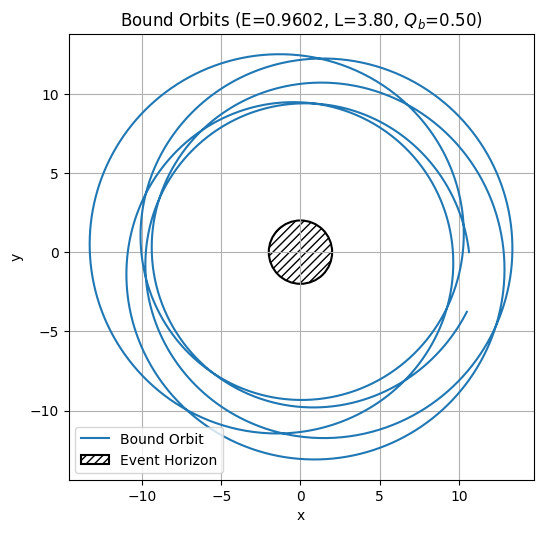

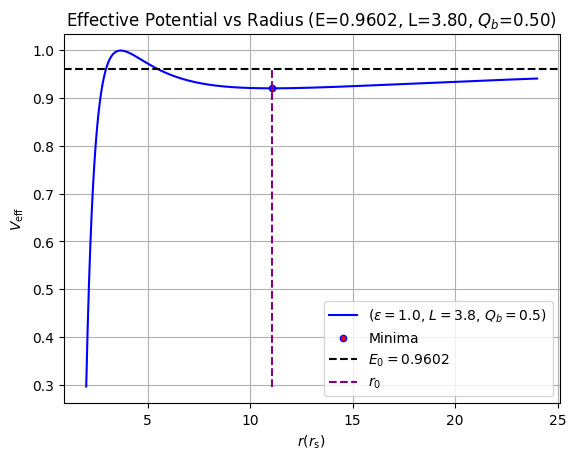

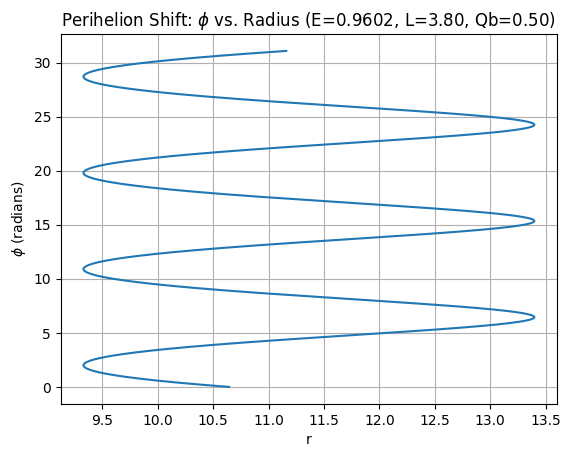

In [26]:
# Block 11 - plot bound orbit test
# initial conditions
r5 = float(extrema_array[5, 0])
E5 = np.sqrt(float(extrema_array[5, 1]))
# E_val5 = E5 + 0.001
E_val5 = E2 + 0.001 # taken from above: E^2 = (v_eff(r_start)) for Q_b = 0.5
Qb_val5 = float(extrema_array[5, 2])
L_val5 = L1
eh_radius = 2 * M1

lam_range5 = [0, 1000]
r_init5 = r5 + 0.005
phi_init5 = 0.0
t_init5 = 0.0

params5 = (E_val5, L_val5, M1, Qb_val5, Q_c0)

r_5 = np.linspace(rs1, 12*rs1, 1000)
v_eff_5 = np.array([v_eff(i, M1, L1, Qb_val5, Q_c0, epsilon=1) for i in r_0])

r_vals5, phi_vals5 = solve_bound_orbit(r_init1, phi_init5, t_init5, lam_range=lam_range5, params=params5)

# polar plot
plt.figure(figsize=(6, 6))
ax = plt.subplot(111, polar=True)
ax.plot(phi_vals5, r_vals5, label='Bound Orbit')
circle_theta = np.linspace(0, 2*np.pi, 500)
ax.fill(circle_theta, np.full_like(circle_theta, eh_radius), edgecolor='black', facecolor='none', hatch='////', linewidth=1.5, label='Event Horizon')
plt.title(f"Bound Orbits (E={E_val1:.4f}, L={L_val5:.2f}, $Q_b$={Qb_val5:.4f})")
ax.legend(loc='upper right')
plt.show()

# cartesian Plot
x_orbit5 = r_vals5 * np.cos(phi_vals5)
y_orbit5 = r_vals5 * np.sin(phi_vals5)

fig, ax = plt.subplots(figsize=(6, 6))
ax.plot(x_orbit5, y_orbit5, label='Bound Orbit')
ax.add_patch(plt.Circle((0, 0), eh_radius, edgecolor='black', facecolor='none', hatch='////', linewidth=1.5, label='Event Horizon'))
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_aspect('equal')
plt.title(f"Bound Orbits (E={E_val5:.4f}, L={L_val5:.2f}, $Q_b$={Qb_val5:.2f})")
ax.legend()
ax.grid(True)
plt.show()

plt.plot(r_5, v_eff_5, label=rf"($\varepsilon={eps}$, $L={L1}$, $Q_b={Qb_val5}$)", color='b')
plt.scatter(extrema_array[5,0], extrema_array[5,1], color='r', s=20, edgecolors='b', label="Minima")
plt.axhline(y=E_val5, color='black', linestyle='--', label=rf'$E_0 = {E_val5:.4f}$')
plt.vlines(x=r_init5, ymin=min(v_eff_5), ymax=E_val5, color='purple', linestyle='--', label=r'$r_0$')
plt.xlabel(r'$r(r_{\mathrm{s}})$')
plt.ylabel(r'$V_{\mathrm{eff}}$')
plt.title(f"Effective Potential vs Radius (E={E_val5:.4f}, L={L_val5:.2f}, $Q_b$={Qb_val5:.2f})")
plt.legend()
plt.grid()
plt.show()

plt.plot(r_vals5, phi_vals5)
plt.xlabel("r")
plt.ylabel(r"$\phi$ (radians)")
plt.title(fr"Perihelion Shift: $\phi$ vs. Radius (E={E_val5:.4f}, L={L_val5:.2f}, Qb={Qb_val5:.2f})")
plt.grid(True)
plt.show()